In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons


In [2]:
def generate_moons(n_samples=1000):
    X, _ = make_moons(n_samples=n_samples, noise=0.1)
    X = X.astype(np.float32)
    return torch.tensor(X)


In [29]:

class DDPM:
    def __init__(self, in_dim=2, hidden_dim=128, out_dim=2, T=100):
        self.T = T
        self.betas = torch.linspace(0.0001, 0.02, T).numpy()
        self.alphas = 1 - self.betas
        self.alphas_cumprod = np.cumprod(self.alphas)
        self.model = self.mlp(in_dim, hidden_dim, out_dim).to(torch.device("cpu"))


    def mlp(self, in_dim, hidden_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim+1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    
    def forward_diffusion(self, x0, t):
        noise = torch.randn_like(x0)
        # print(f"{self.alphas_cumprod[t]=}")
        mean = torch.sqrt(torch.tensor(self.alphas_cumprod[t]))[:, None] * x0
        std = torch.sqrt(1 - torch.tensor(self.alphas_cumprod[t]))[:, None]
        # print(f"{mean.shape=}")
        return mean + std * noise, noise
    
    def get_eps_from_model(self, x, t):
        with torch.no_grad():
            return self.model(torch.cat((x, torch.full((x.shape[0], 1), t / self.T)), dim=1))
    
    def compute_mu(self, x, eps, t):
        return (x - self.betas[t] / np.sqrt(1 - self.alphas_cumprod[t]) * eps) / np.sqrt(self.alphas[t])

    def sample(self, n_samples=1000):
        x = torch.randn(n_samples, 2)
        for t in reversed(range(self.T)):
            z = torch.randn_like(x) if t > 0 else 0
            eps = self.get_eps_from_model(x, t)
            mu = self.compute_mu(x, eps, t)
            x = mu + np.sqrt(self.betas[t]) * z
        return x.detach().numpy()

def train_ddpm(ddpm_model, epochs=5000, batch_size=128, lr=3e-2, n_samples=5000):

    optimizer = optim.Adam(ddpm_model.model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    dataset = generate_moons(n_samples)
    for epoch in range(epochs):
        idx = torch.randint(0, dataset.shape[0], (batch_size,))
        x0 = dataset[idx]
        # print(f"{x0.shape=}")
        t = np.random.randint(0, ddpm_model.T, (batch_size,))
        xt, noise = ddpm_model.forward_diffusion(x0, t)
        noise_pred = ddpm_model.model(torch.cat((xt, torch.tensor(t[:, None]) / ddpm_model.T), dim=1))
        loss = criterion(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.0329
Epoch 500, Loss: 0.5247
Epoch 1000, Loss: 0.4697
Epoch 1500, Loss: 0.4275
Epoch 2000, Loss: 0.6073
Epoch 2500, Loss: 0.5576
Epoch 3000, Loss: 0.5186
Epoch 3500, Loss: 0.5126
Epoch 4000, Loss: 0.5124
Epoch 4500, Loss: 0.4712
Epoch 5000, Loss: 0.6432
Epoch 5500, Loss: 0.5731
Epoch 6000, Loss: 0.4946
Epoch 6500, Loss: 0.5582
Epoch 7000, Loss: 0.4958
Epoch 7500, Loss: 0.6149
Epoch 8000, Loss: 0.4571
Epoch 8500, Loss: 0.6311
Epoch 9000, Loss: 0.5514
Epoch 9500, Loss: 0.6429
Epoch 10000, Loss: 0.5336
Epoch 10500, Loss: 0.5245
Epoch 11000, Loss: 0.6015
Epoch 11500, Loss: 0.5458
Epoch 12000, Loss: 0.4647
Epoch 12500, Loss: 0.5095
Epoch 13000, Loss: 0.5041
Epoch 13500, Loss: 0.5589
Epoch 14000, Loss: 0.5088
Epoch 14500, Loss: 0.4886
Epoch 15000, Loss: 0.5097
Epoch 15500, Loss: 0.6358
Epoch 16000, Loss: 0.5812
Epoch 16500, Loss: 0.5398
Epoch 17000, Loss: 0.4523
Epoch 17500, Loss: 0.5890
Epoch 18000, Loss: 0.4488
Epoch 18500, Loss: 0.5449
Epoch 19000, Loss: 0.5155
Epoch 1950

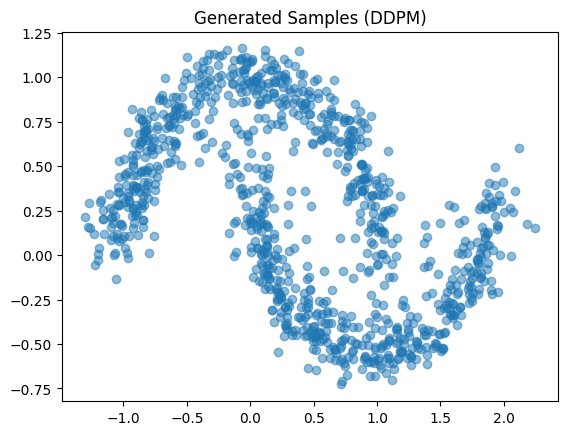

In [33]:
ddpm = DDPM()
train_ddpm(ddpm, epochs=20000, batch_size=128, lr=1e-3, n_samples=5000)
samples = ddpm.sample()
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title("Generated Samples (DDPM)")
plt.show()